# Problem Set 1 - KNN
## CSCI 5622 - Fall 2021

For today's assignment, we will be implementing our own K-Nearest Neighbors (KNN) algorithm.

*But Professor Quigley, hasn't someone else already written KNN before?*

Yes, you are not the first to implement KNN, or basically any algorithm we'll work with in this class. But
1. I'll know that you know what's really going on
2. You'll know you can do it, because
    1. someday you might have to implement some machine learning algorithm from scratch - maybe for a new platform (do you need to run python on your SmartToaster just to get it to learn how users like their toast?), maybe because you want to tweak the algorithm (there's always a better approach...),
    2. maybe because you're working on something important, and you need to control exactly what's on there (should you really be running anaconda on your secret spy plane?).

That said - we're not going to implement *everything*. We'll start by importing a few helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.neighbors
import sklearn.datasets
import math
from collections import Counter

*Wait a minute - didn't we just import Scikit-learn (sklearn)? The package with baked-in machine learning tools?*

Yes - but it also has a ton of helper functions, including a dataset we'll be using later. But first, let's also create a dataset to play with and start working to build out our own classifier.

[0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1
 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0
 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1]


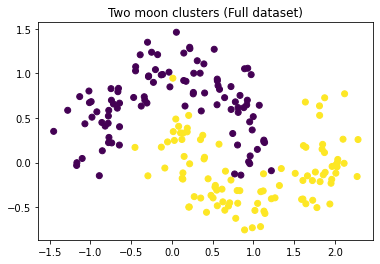

In [2]:
X, y = sklearn.datasets.make_moons(n_samples=200, noise=0.19, random_state=42)
X_train, y_train = X[:100], y[:100]
X_test, y_test = X[100:], y[100:]
plt.title("Two moon clusters (Full dataset)")
print(y_train)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

We have data!

Now, let's set up a KNNClassifier class. 

The KNNClassifier class will have similar design to the K-Nearest Neighbors classifier class from *scikit-learn*:
- Initialize the classifier with corresponding parameters (number of neighbors k)
- Fit the classifier using the training data
- Predict the class of new points `X_test`

We've written out a lot of the structure for you so it will be consistent and we can use / reuse it, and you can focus on the "important" stuff that actually relates to the machine learning itself.

In [3]:

class KNNClassifier:

    def __init__(self, k = 5):
        """
        Initialize our custom KNN classifier
        PARAMETERS

        k - the number of nearest neighbors to consider for classification
        """
        self._k = k
        self._model = None
        self._y = None
        self.label_to_index = None
        self.index_to_label = None
        self.counts = 0

    def fit(self, features, labels):
        """
        
        :param features: 2-D np.array of shape (number training samples, features dimension)
        :param labels: 1-D np.array of shape (number training samples,)
        :return: self
        """
        
        self._model = sklearn.neighbors.BallTree(features)
        self._y = labels
        self.counts = self.get_counts()
        # Should be used to map the classes to {0,1,..C-1} where C is the number of classes
        self.label_to_index = dict(zip(sorted(self.counts.keys()), range(len(self.counts))))
        self.index_to_label = dict(zip(range(len(self.counts)), sorted(self.counts.keys())))
        return self

    def get_counts(self):
        """
        Creates a dictionary storing the count of elements of each class
        :return: dict where the keys are the classes and values are the counts
        """

        counts = dict()
        
        #BEGIN Workspace 1.1
        #TODO: Modify and/or add to counts so that it returns a count of each answer class found in y
        #END Workspace 1.1

        for i in self._y:
          counts[i] = counts.get(i, 0) + 1
        return counts

    def majority_vote(self, indices):
        """
        Given indices, report the majority label of those points.
        FOR A TIE, report the most common label in the data set.
        :param indices: indices of training neighbors of shape (M, k) where k the classifier parameter
        :return: The majority label for each set of indices, shape (M,)
        """

        if len(indices) != self._k:
          print("Number of indices given is less than number of Neighbours K")
          return;

        labels = 0 # REPLACE
        #BEGIN Workspace 1.2
        # TODO: Determine majority, assign it to label

        vote_store = {} # to store the classes of the neighbours and their counts in the dictionary
        for idx in indices:
          temp = self._y[idx]
          vote_store[temp]=vote_store.get(temp,0)+1;

        max_frequency = max(vote_store.values()) #maximum frequency in the dictionary to determine which class has got the majority vote
        
        classes_with_max_keys = [] #we will store the classes which has secured max_frequency in a list
        for key in vote_store:
          if vote_store[key] == max_frequency:
            classes_with_max_keys.append(key);


        if len(classes_with_max_keys)==1: #there is only one element in the list therefore we will assign the value at the 0th index to the labels and then return
          labels = classes_with_max_keys[0];

        else: #if the list contains more than one element then it is a tie
          train_data_classes_frequencies = self.get_counts()
          maximum_frequency = 0
          for key in classes_with_max_keys: #iterate over classes with max keys
            if train_data_classes_frequencies[key] > maximum_frequency: #determine which class had occured more in the training data set
              maximum_frequency = train_data_classes_frequencies[key]; #keep track of the msximum_frequency
              labels = key;#assign that class to the labels which we have to return

        #END Workspace 1.2
        return labels

    #smoothed majority function for K to perform consistently using Gaussian Kernel to demonstrate consistent classifier
    def smoothed_majority_vote(self, neighbor_indices, neighbor_distances=None):
      labels = [] 
      kernel_width = 2

      if len(neighbor_indices) != self._k:
        print("Number of indices given is less than number of Neighbours K")
        return;

      weighted_vote_store = {} # to store the classes of the neighbours and their counts in the dictionary
      for idx,dist in zip(neighbor_indices, neighbor_distances):
        temp = self._y[idx]
        gaussian_distance = np.exp(-(dist**2)/kernel_width)
        # print('Gaussian Distance {}'.format(gaussian_distance))
        weighted_vote_store[temp] = weighted_vote_store.get(temp,0) + gaussian_distance;
    
      max_weight = max(weighted_vote_store.values()) #maximum weight associated with which class in the dictionary to determine which class has got the majority weight
      classes_with_max_keys = [] #we weill store the classes which has secured max_weight in a list

      for key in weighted_vote_store:
        if weighted_vote_store[key] == max_weight:
          classes_with_max_keys.append(key);


      if len(classes_with_max_keys)==1: #there is only one element in the list therefore we will assign the value at the 0th index to the labels and then return
        labels = classes_with_max_keys[0];

      else: #if the list contains more than one element then it is a tie then return the class label which is the majority
        train_data_classes_frequencies = self.get_counts()
        maximum_frequency = 0
        for key in classes_with_max_keys: #iterate over classes with max keys
          if train_data_classes_frequencies[key] > maximum_frequency: #determine which class had occured more in the training data set
            maximum_frequency = train_data_classes_frequencies[key]; #keep track of the maximum_frequency
            labels = key;#assign that class to the labels which we have to return
      
      return labels
      
    def predict(self, points, flag = False):
        """
        Given new data points, classify then according to the training data provided in fit and number of neighbors k
        :param point: feature vectors (num_points, num_features)
        :return: 1-D np.array of predicted classes of shape (num_points,)
        """

        #BEGIN Workspace 1.3
        #TODO: perform classification of points here
        #HINT: use the majority function created above
        #HINT: use the euclidean distance discussed in lecture to find nearest neighbors
        #END Workspace 1.3
        predicted_answers = []
        distances, indices = self._model.query(points, self._k)

        if(flag == False): #for normal Majority vote function  
          for idx in indices:
            predicted_answers.append(self.majority_vote(idx))

        else:
          for idx, dist in zip(indices,distances):
            predicted_answers.append(self.smoothed_majority_vote(idx,dist))

        return np.array(predicted_answers)    

    def confusion_matrix(self, features_test, labels_test, flag = False):
        """
        Generate the confusion matrix for the given test data
        :param features_test: an np.array of feature vectors of test points, shape (N, n_features)
        :param labels_test: he corresponding correct classes of our test set, shape (N,)
        :return: an C*C np.array of counts, where C is the number of classes in our classifier
        """
        c_matrix = np.array(None) # REPLACE
        labels_test_set = set(labels_test)
        c_matrix = np.zeros((len(labels_test_set),len(labels_test_set)), dtype=int)
        if flag == False:
          predicted_test = self.predict(features_test)
        else:
          predicted_test = self.predict(features_test, True) #calling majority vote with smoothed Gaussian Kernel

        for predicted, actual in zip(predicted_test, labels_test):
          c_matrix[actual][predicted]+=1;
        
        #BEGIN Workspace 1.4
        #TODO: Run classification for the test set, compare to test answers, and add counts to matrix

        #END Workspace 1.4
        return c_matrix

    def accuracy(self, features_test, labels_test, flag = False):
        """
        Generate an accuracy score for the classifier based on the confusion matrix
        PARAMETERS
        C - an np.array of counts
        RETURN
        score - an accuracy score
        """
        score = 0
        #BEGIN Workspace 1.5
        #TODO: Compute accuracy of the classification of X_test
        
        #END Workspace 1.5
        c_matrix = self.confusion_matrix(features_test, labels_test, flag)
        score = np.sum(c_matrix.diagonal())/c_matrix.sum()#sum of diagonal elements divided by sum of the matrix
        return score


*But professor, this code isn't complete!*

### Problem 1: Complete our KNN Classifier - 25 Points

1.1 - Complete the `get_counts` function to return the count of each class found in the training set (5 points)

1.2 - Complete the `majority_vote` function to determine the majority class of a series of neighbors (5 points)

1.3 - Complete the `predict` function to capture the predicted class of a new datapoint (5 points)

 - HINT: Use the BallTree documentation to determine how to retrieve neighbors from the model (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)

1.4 - Complete the `confusion_matrix` function to reveal the results of classification (5 points)

1.5 - Complete the `accuracy` function to get accuracy of the classifier based on a given test data (5 points)

Below, we'll be using our KNNClassifier (sent in as "model") to show how we would predict any points in space given the input data.

In [4]:
def show_decision_surface(model):
    """
    Helper function to visualize the decision surface of model
    :param model: Initialized KNNClassifier
    :return: None
    """
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    x_grid = np.arange(x_min, x_max, 0.1)
    y_grid = np.arange(y_min, y_max, 0.1)
    xx, yy = np.meshgrid(x_grid, y_grid)
    r1, r2 = xx.reshape(-1,1), yy.reshape(-1,1)
    grid = np.hstack((r1,r2))
    y_hat = model.predict(grid)
    zz = y_hat.reshape(xx.shape)
    plt.contourf(xx, yy, zz, cmap='PiYG')
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.show()

1.6. Try different values of k and report their accuracies and confusion matrices on the test set. Make sure to keep `random_state=42` so that the reported values don't change when code is re-run (5 points)

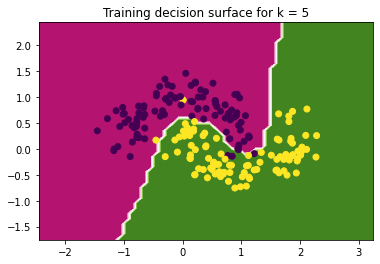

[[47  2]
 [ 1 50]]
0.97


In [5]:
#BEGIN Workspace 1.6
#TODO: Try different Ks        
kk = 5
model = KNNClassifier(k=kk)
model = model.fit(X_train, y_train)
plt.title("Training decision surface for k = {}".format(kk))
show_decision_surface(model)
C = model.confusion_matrix(X_test,y_test)
accuracy_score = model.accuracy(X_test,y_test)
print(C)
print(accuracy_score)
#END Workspace 1.6

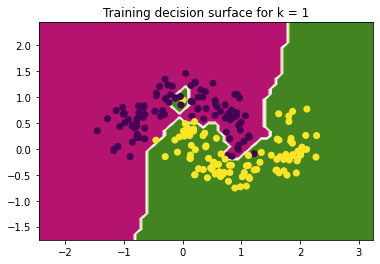

The confusion matrix is :: 
[[44  5]
 [ 3 48]]
The accuracy score is ::  0.92


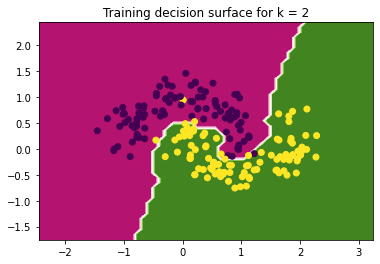

The confusion matrix is :: 
[[48  1]
 [ 3 48]]
The accuracy score is ::  0.96


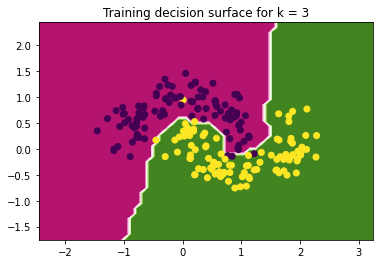

The confusion matrix is :: 
[[47  2]
 [ 2 49]]
The accuracy score is ::  0.96


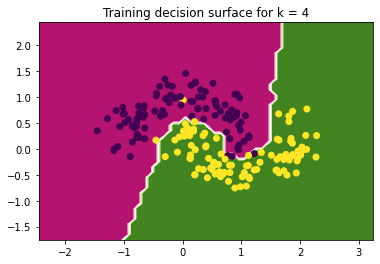

The confusion matrix is :: 
[[47  2]
 [ 2 49]]
The accuracy score is ::  0.96


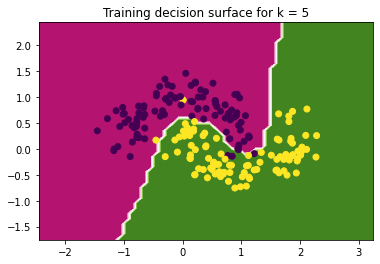

The confusion matrix is :: 
[[47  2]
 [ 1 50]]
The accuracy score is ::  0.97


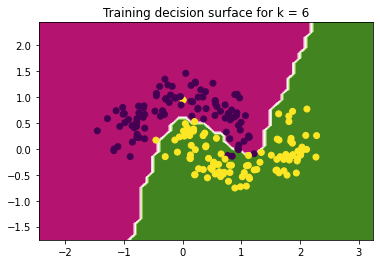

The confusion matrix is :: 
[[47  2]
 [ 2 49]]
The accuracy score is ::  0.96


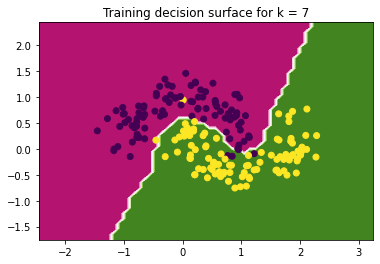

The confusion matrix is :: 
[[47  2]
 [ 1 50]]
The accuracy score is ::  0.97


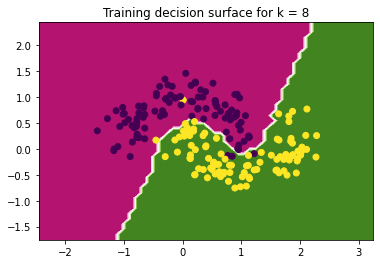

The confusion matrix is :: 
[[47  2]
 [ 1 50]]
The accuracy score is ::  0.97


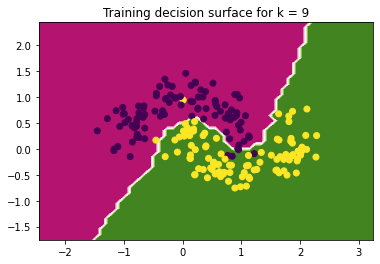

The confusion matrix is :: 
[[47  2]
 [ 1 50]]
The accuracy score is ::  0.97


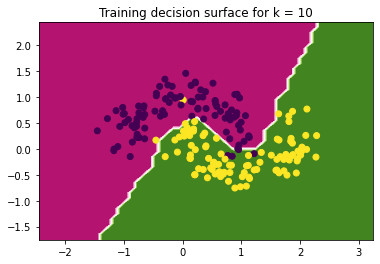

The confusion matrix is :: 
[[47  2]
 [ 1 50]]
The accuracy score is ::  0.97


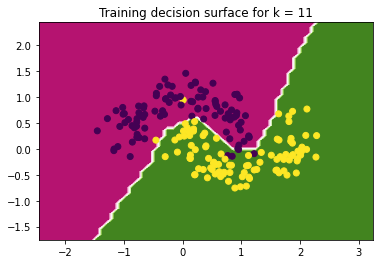

The confusion matrix is :: 
[[46  3]
 [ 1 50]]
The accuracy score is ::  0.96


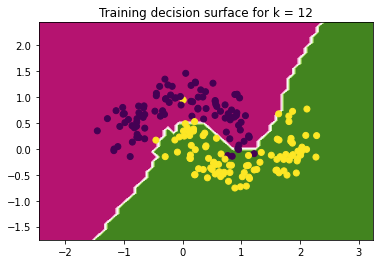

The confusion matrix is :: 
[[47  2]
 [ 4 47]]
The accuracy score is ::  0.94


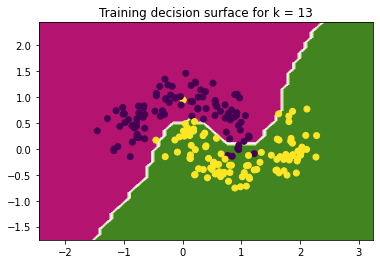

The confusion matrix is :: 
[[45  4]
 [ 2 49]]
The accuracy score is ::  0.94


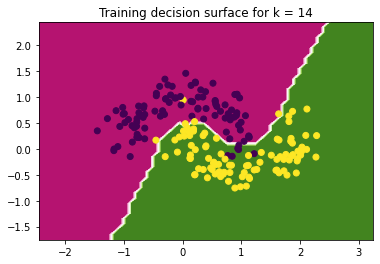

The confusion matrix is :: 
[[45  4]
 [ 4 47]]
The accuracy score is ::  0.92


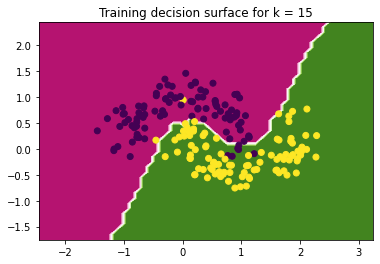

The confusion matrix is :: 
[[45  4]
 [ 3 48]]
The accuracy score is ::  0.93


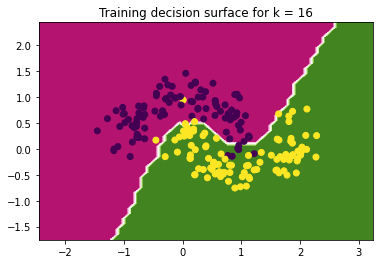

The confusion matrix is :: 
[[45  4]
 [ 4 47]]
The accuracy score is ::  0.92


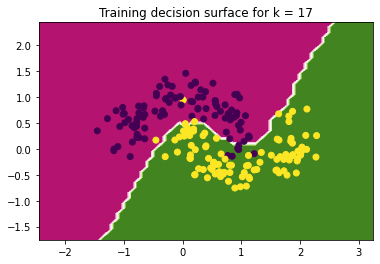

The confusion matrix is :: 
[[45  4]
 [ 3 48]]
The accuracy score is ::  0.93


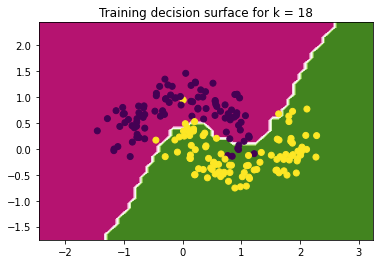

The confusion matrix is :: 
[[45  4]
 [ 3 48]]
The accuracy score is ::  0.93


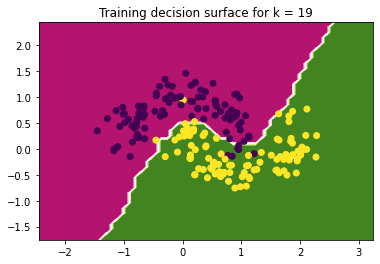

The confusion matrix is :: 
[[45  4]
 [ 1 50]]
The accuracy score is ::  0.95


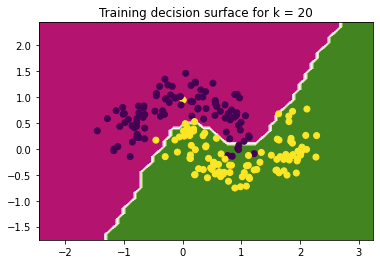

The confusion matrix is :: 
[[45  4]
 [ 3 48]]
The accuracy score is ::  0.93


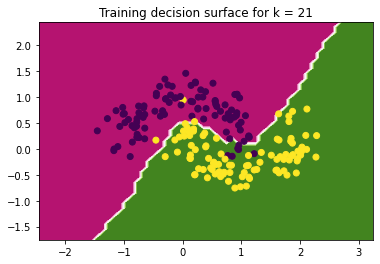

The confusion matrix is :: 
[[45  4]
 [ 2 49]]
The accuracy score is ::  0.94


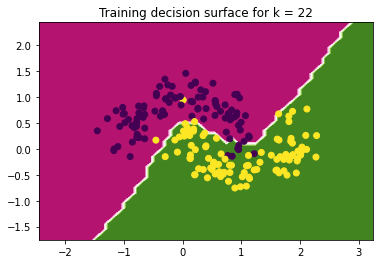

The confusion matrix is :: 
[[45  4]
 [ 2 49]]
The accuracy score is ::  0.94


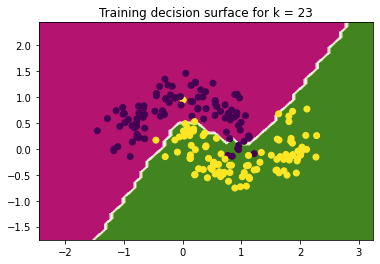

The confusion matrix is :: 
[[45  4]
 [ 2 49]]
The accuracy score is ::  0.94


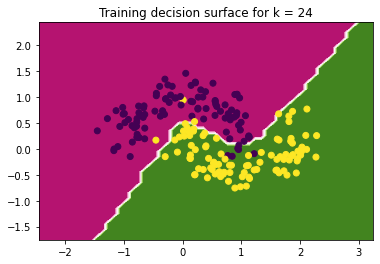

The confusion matrix is :: 
[[45  4]
 [ 3 48]]
The accuracy score is ::  0.93


In [6]:
# Code for 1.6
for kk in range(1,25):
  model = KNNClassifier(k=kk)
  model = model.fit(X_train, y_train)
  plt.title("Training decision surface for k = {}".format(kk))
  show_decision_surface(model)
  C = model.confusion_matrix(X_test,y_test)
  accuracy_score = model.accuracy(X_test,y_test)
  print("The confusion matrix is :: ")
  print(C)
  print("The accuracy score is :: ",accuracy_score)

In [ ]:
#util method to plot the train and test curve of the model for a particular K value

def plot_train_test(k_values, accuracy_scores_train, accuracy_scores_test,label1='Train accuracy', label2 = 'Test accuracy'):
  plt.plot(k_values,accuracy_scores_train, label=label1)
  plt.plot(k_values,accuracy_scores_test, label=label2)
  difference = [abs(x - y) for x, y in zip(accuracy_scores_train, accuracy_scores_test)]
  best_k_values = []
  min_difference = min(difference)
  for i in range(0, len(difference)):
    if difference[i] == min_difference:
      best_k_values.append(i+1)
  plt.legend()
  plt.show()
  print(difference)
  print(best_k_values)

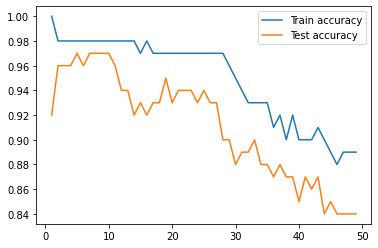

[0.07999999999999996, 0.020000000000000018, 0.020000000000000018, 0.020000000000000018, 0.010000000000000009, 0.020000000000000018, 0.010000000000000009, 0.010000000000000009, 0.010000000000000009, 0.010000000000000009, 0.020000000000000018, 0.040000000000000036, 0.040000000000000036, 0.05999999999999994, 0.039999999999999925, 0.05999999999999994, 0.039999999999999925, 0.039999999999999925, 0.020000000000000018, 0.039999999999999925, 0.030000000000000027, 0.030000000000000027, 0.030000000000000027, 0.039999999999999925, 0.030000000000000027, 0.039999999999999925, 0.039999999999999925, 0.06999999999999995, 0.05999999999999994, 0.06999999999999995, 0.04999999999999993, 0.040000000000000036, 0.030000000000000027, 0.050000000000000044, 0.050000000000000044, 0.040000000000000036, 0.040000000000000036, 0.030000000000000027, 0.050000000000000044, 0.050000000000000044, 0.030000000000000027, 0.040000000000000036, 0.040000000000000036, 0.06000000000000005, 0.040000000000000036, 0.040000000000000

In [ ]:
#We are trying to check for which K the model is performing good on both train and test data set 
#so we try calculating the min difference between the train and test accuracy and for which value of K

k_values = []
accuracy_scores_train = []
accuracy_scores_test = []

for kk in range(1,50):
  model = KNNClassifier(k=kk)
  model = model.fit(X_train, y_train)
  k_values.append(kk)
  accuracy_scores_train.append(model.accuracy(X_train,y_train))
  accuracy_scores_test.append(model.accuracy(X_test,y_test))

plot_train_test(k_values,accuracy_scores_train,accuracy_scores_test)


#### Write up for 1.6 here

For the values k={5,7,8,9,10} the accuracy is 0.97 and the true negative is 47/50 and the True positives are 50/50. It has 100% accuracy for TPR where as for TNR it is 47/50. Basically by checking the train accuracy and the test accuracy it is not a overfit because if it was overfitting train accuracy would have been very high and the test accuracy would have been very low. But for the above mentioned case both train and test accuracy differences are similar therefore K = {5,7,8,9,10} are the best values of K for the given data set

### Bonus (for the avid machine learner) (5 Points)
1.7. For which value of $k$ is the classifier consistent? (Only worry about this question within our `random_state=42` constraint)



1.8. Edit your `KNNClassifier` so that it's consistent for all $k$ (This solution should work beyond our `random_state=42` constraint, but retain the constraint when submitting your code above)



For a definition of a consistent classifier, refer to [Consistent Classification, Firm and Soft by Barum](https://proceedings.neurips.cc/paper/1996/file/7bb060764a818184ebb1cc0d43d382aa-Paper.pdf) (The answer is found in the abstract and introduction sections of the paper) 

#### Write up for the bonus

1.7 From the above plot for train test data we can clearly see, K is performing good on K={5,7,8,9,10} . But I think K=10 will be the good value of K because, here the dataset size is very small, so it performs well on K = {5,7,8,9,10} as the size of the dataset increases, the smaller value of K can cause overfitting. I feel it is safer to pick the larger value of K if both larger K and smaller K has the same accuracy as in this case. But we must be careful not to pick a too larger K, because it can cause underfitting. But K=10 in this case is not that larger value of K to cause an underfitting. Therefore K=10 is the value where the classifier is consistent. We will pick a higher value of K if lower value of K and higher value of K has the same accuracy.

1.8 I saw these two links and I'm attaching the two links below, that we can KNN smooth by using Gaussian Kernel. 

https://courses.cs.washington.edu/courses/cse416/19sp/12nearest_neighbor_methods.pdf

https://towardsdatascience.com/make-your-knn-smooth-with-gaussian-kernel-7673fceb26b9

Let us try that instead of our majority vote function and see how the accuracy is getting impacted when we use smoothed Gaussian Kernel.

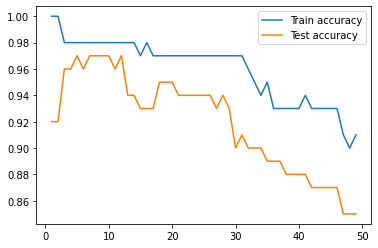

[0.07999999999999996, 0.07999999999999996, 0.020000000000000018, 0.020000000000000018, 0.010000000000000009, 0.020000000000000018, 0.010000000000000009, 0.010000000000000009, 0.010000000000000009, 0.010000000000000009, 0.020000000000000018, 0.010000000000000009, 0.040000000000000036, 0.040000000000000036, 0.039999999999999925, 0.04999999999999993, 0.039999999999999925, 0.020000000000000018, 0.020000000000000018, 0.020000000000000018, 0.030000000000000027, 0.030000000000000027, 0.030000000000000027, 0.030000000000000027, 0.030000000000000027, 0.030000000000000027, 0.039999999999999925, 0.030000000000000027, 0.039999999999999925, 0.06999999999999995, 0.05999999999999994, 0.05999999999999994, 0.04999999999999993, 0.039999999999999925, 0.05999999999999994, 0.040000000000000036, 0.040000000000000036, 0.050000000000000044, 0.050000000000000044, 0.050000000000000044, 0.05999999999999994, 0.06000000000000005, 0.06000000000000005, 0.06000000000000005, 0.06000000000000005, 0.06000000000000005, 0

In [ ]:
k_values = []
accuracy_scores_train = []
accuracy_scores_test = []

for kk in range(1,50):
  model = KNNClassifier(k=kk)
  model = model.fit(X_train, y_train)
  k_values.append(kk)
  #we are passing true here so that the util method will calculate based on gaussian kernel instead of the normal kernel
  accuracy_scores_train.append(model.accuracy(X_train,y_train, True))
  accuracy_scores_test.append(model.accuracy(X_test,y_test, True))

plot_train_test(k_values,accuracy_scores_train,accuracy_scores_test)

From the above plot we can clearly see it retains all the nearest neighbours from the normal majority vote K = {5,7,8,9,10} and in addition to that we have got K=12 as well. A new K, therefore we can say that the gaussian kernel majority vote function performs better than the normal majority vote function for the given data set.

***
OK - now we've demonstrated that our KNN classifier works, let's think about our problem space! 

## Our Dataset - Identifying Digits from Images

It's a pretty common problem - just imagine working at the post office, and you're handed a hand-written check,
and you have to identify exactly what it says.
Did they pay 500 or 600 dollars? Is the letter going to 80309 (campus) or 30309 (Atlanta)?

Let's be a little smart about this - let's up some classes and helper functions to help us out.

### Problem 2: Implement KNN on Digits dataset - 25 Points

2.1 **Randomly** divide our digit dataset into training and testing sets (10 Points)

2.2 Report the number of examples in training and testing, as well as measuring then number of pixels in each image (5 points)

2.3 Create a confusion matrix of our classifier for K = 5 (10 points) *HINT: Doing this may cause you to catch mistakes in your classifier. Go fix those!*

In [ ]:

class Numbers:
    def __init__(self, k=5):
        #load data from sklearn
        
        data = sklearn.datasets.load_digits()
        features = data["data"]
        self.labels = data["target"]
        self.features = features.reshape(features.shape[0], -1)
        
        # BEGIN Workspace 2.1      

        #Tried this random eighty percent split, the problem was the points taken at the each time I run is different, 
        # so the report that I write is not matching with the output . Therefore, I've commented it.

        # mask = np.random.rand(len(features)) <= 0.8
        # train_data = self.features[mask]
        # train_labels = self.labels[mask]

        # test_data = self.features[~mask]
        # test_labels = self.labels[~mask]

        eighty_percent = math.floor(len(features)*0.8)
        train_data = self.features[0:eighty_percent]
        train_labels = self.labels[0:eighty_percent]

        test_data = self.features[eighty_percent:-1]
        test_labels = self.labels[eighty_percent:-1]



        self.train_x = np.array(train_data) # A 2D np.array of training examples, REPLACE
        self.train_y = np.array(train_labels) # A 1D np.array of training answers, REPLACE
        self.test_x = np.array(test_data) # A 2D np.array of testing examples, REPLACE
        self.test_y = np.array(test_labels) # A 1D np.array of testing answers, REPLACE
        self.k_value = k #setting the k_value
        self.classifier = KNNClassifier(k) # KNNClassifier, REPLACE

        
        # TODO: - Divide our dataset into Train and Test datasets (80/20 split),
        #        replacing the variables above
        #       - Initialize the classifier

        #END Workspace 2.1
        
    def report(self):
        """
        Report information about the dataset using the print() function
        """
        #BEGIN Workspace 2.2
        #TODO: Create printouts for reporting the size of each set and the size of each datapoint
        
        print("Total Data size:: ", len(self.features))

        print(" Training set data size::",self.train_x.size)
        print(" Training set labels size::",self.train_y.size)
        print(" Test Set Data size::",self.test_x.size)
        print(" Test Set labels size ::",self.test_y.size)
        
        print(" no of pixels per data point ::",len(np.array(self.train_x[0])))

        print(" Shape of Training Data:",self.train_x.shape)
        print(" Shape of Training labels:",self.train_y.shape)
        print(" Shape of Test data:",self.test_x.shape)
        print(" Shape of Test labels:",self.test_y.shape)

        #END Workspace 2.2
        

    def classify(self):
        """
        Fits classifier using the training data and generate a confusion matrix for the test data
        then return the confusion matrix
        """
        #BEGIN Workspace 2.3.a
        #TODO: Create classifier from training data, generate confusion matrix for test data
        # self.classifier.fit(# TODO)
        #END Workspace 2.3.a
        count = 0
        model = self.classifier.fit( self.train_x,  self.train_y)
        c_matrix = model.confusion_matrix(self.test_x, self.test_y)
        return  c_matrix
        
    
    def mistakes_report(self):
        model = self.classifier.fit( self.train_x,  self.train_y)
        Y_predicted = model.predict(self.test_x)
        count = 0
        for idx in range(0,len(Y_predicted)):
          if Y_predicted[idx]!=self.test_y[idx]:
            count+=1
            print('Predicted {} instead of {}'.format(Y_predicted[idx], self.test_y[idx]))
            digit_image = self.test_x[idx]
            image = digit_image.reshape(8, -1)
            print("Image for digit {}".format(self.test_y[idx]))
            plt.matshow(image)
            plt.show()
        print("Number of mismatches :: ", count)
    
    def accuracy(self):
        c_matrix = self.classify()
        accuracy = np.sum(c_matrix.diagonal())/c_matrix.sum()
        #BEGIN Workspace 2.3.b
        #TODO: Compute accuracy using confusion matrix
        #END Workspace 2.3.b
        return accuracy

    def view_digit(self, index):
        """
        Display an image of a digit
        PARAMETERS
        digitImage - a data object from the dataset
        """
        #TODO: process digit_image to matrix "image"
        digit_image = self.features[index]
        image = digit_image.reshape(8, -1)
        print("Image for digit {}".format(self.labels[index]))
        plt.matshow(image)
        plt.show()

    def number_count(self):
      l = list(self.labels)
      for i in range(0,10):
        print("Count for {} is {}".format(i, l.count(i)))


    @staticmethod
    def display_confusion(c_matrix):
        fig, ax = plt.subplots()
        ax.matshow(c_matrix, cmap=plt.cm.Blues)
        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[0]):
                ax.text(i, j, str(c_matrix[j,i]), va='center', ha='center')
        plt.show()
        

Total Data size::  1797
 Training set data size:: 91968
 Training set labels size:: 1437
 Test Set Data size:: 22976
 Test Set labels size :: 359
 no of pixels per data point :: 64
 Shape of Training Data: (1437, 64)
 Shape of Training labels: (1437,)
 Shape of Test data: (359, 64)
 Shape of Test labels: (359,)
Accuracy is ::  0.9610027855153204
Image for digit 6


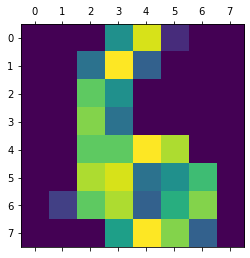

In [ ]:
numbers = Numbers()
numbers.report()
print("Accuracy is :: ",numbers.accuracy())
numbers.view_digit(290)

Predicted 9 instead of 8
Image for digit 8


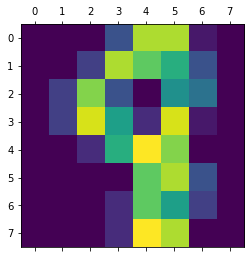

Predicted 1 instead of 8
Image for digit 8


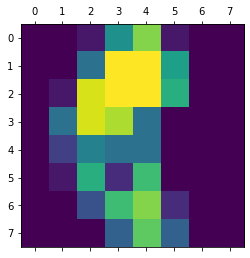

Predicted 4 instead of 0
Image for digit 0


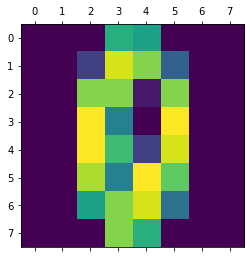

Predicted 5 instead of 9
Image for digit 9


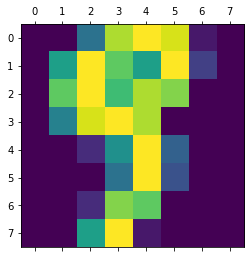

Predicted 7 instead of 3
Image for digit 3


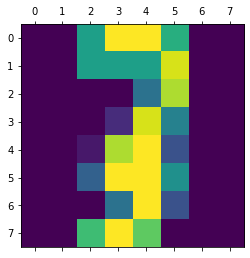

Predicted 8 instead of 3
Image for digit 3


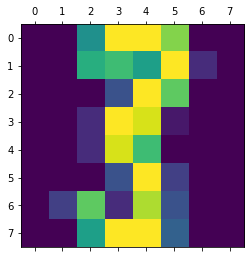

Predicted 9 instead of 4
Image for digit 4


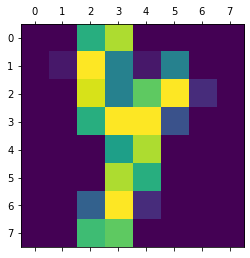

Predicted 3 instead of 9
Image for digit 9


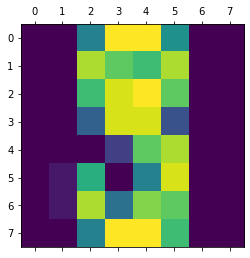

Predicted 8 instead of 4
Image for digit 4


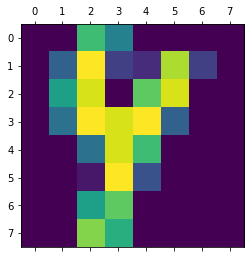

Predicted 5 instead of 9
Image for digit 9


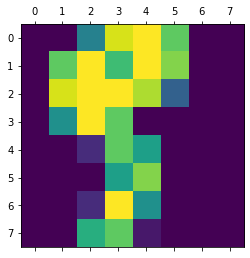

Predicted 7 instead of 8
Image for digit 8


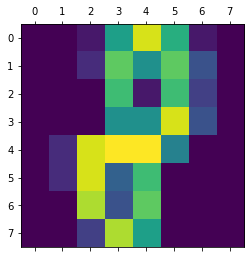

Predicted 2 instead of 3
Image for digit 3


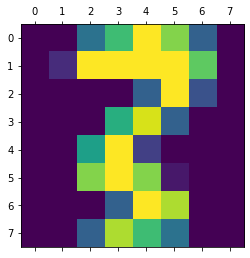

Predicted 5 instead of 3
Image for digit 3


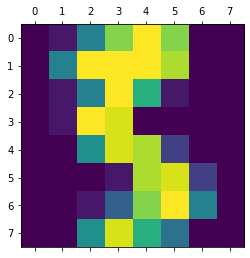

Predicted 1 instead of 8
Image for digit 8


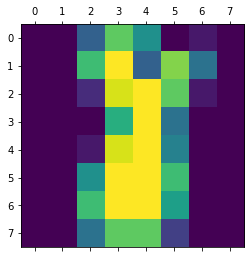

Number of mismatches ::  14


In [ ]:
#we are checking which digits are getting misclassified and are classified as what digits in this mistakes_report function
numbers.mistakes_report()

*Wow, I can't believe we just created a KNN Classifier for multiple classes - but can't we make it better?*

Yes, we saw above that our classifier didn't work perfectly. Let's explore that issue a little further by turning the $K$ and random split knobs

### Problem 3: Improving KNN on Digits - 20 Points

3.1 Determine which classes are most often confused (from our confusion matrix above), inspect some examples of these digits (using the `view_digit` function in our Numbers class), and write a brief (4 - 5 sentences) description of why you think these particular numbers may be misclassified. (10 pts)

3.2 Explore the influence of the number of nearest neighbors (i.e. try changing our K). Plot the relationship between K and accuracy, and write a brief (4 - 5 sentences) description of how this factor impacts our accuracy. To mitigate the effect of randomness from the split, you have to run the evaluation multiple times and report the mean accuracy. Make sure the runs for different Ks are done on the same splits. (5 pts)

3.3 Explore the influence of the train / test split of our data (i.e. copy our Numbers class into Numbers2 below and try changing the split for our dataset). Plot the relationship between the split % and accuracy, and write a brief (4 - 5 sentences) description of its impact. (5 pts)

You can complete the `NumbersKnobs` class and use it as you see fit. But it's only necessary for 3.3

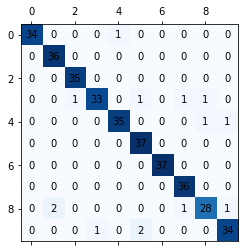

Predicted 9 instead of 8
Image for digit 8


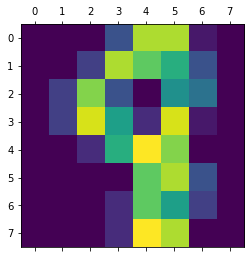

Predicted 1 instead of 8
Image for digit 8


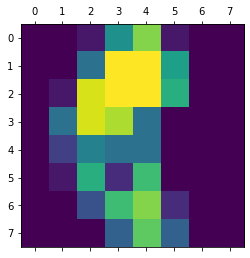

Predicted 4 instead of 0
Image for digit 0


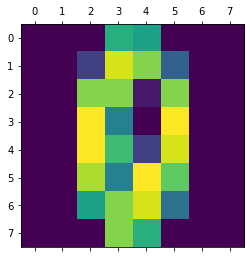

Predicted 5 instead of 9
Image for digit 9


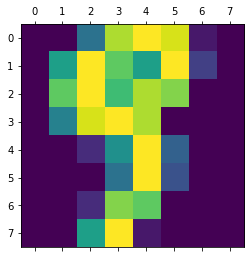

Predicted 7 instead of 3
Image for digit 3


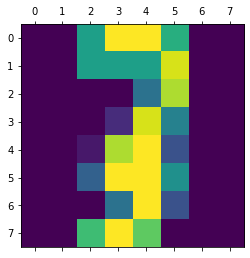

Predicted 8 instead of 3
Image for digit 3


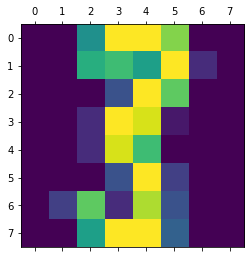

Predicted 9 instead of 4
Image for digit 4


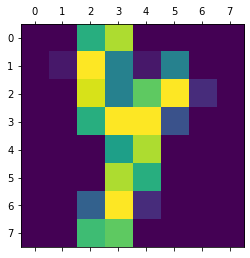

Predicted 3 instead of 9
Image for digit 9


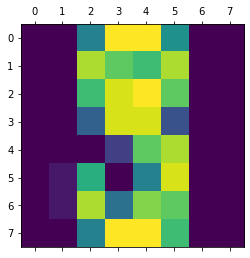

Predicted 8 instead of 4
Image for digit 4


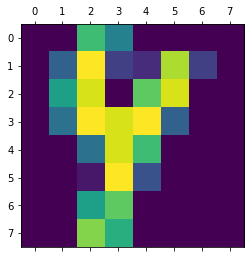

Predicted 5 instead of 9
Image for digit 9


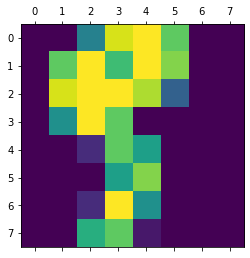

Predicted 7 instead of 8
Image for digit 8


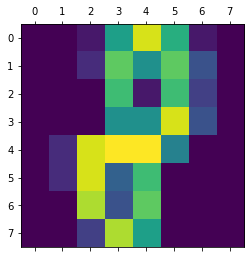

Predicted 2 instead of 3
Image for digit 3


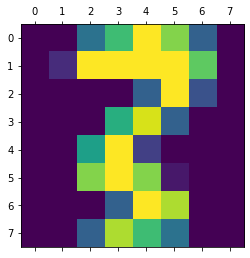

Predicted 5 instead of 3
Image for digit 3


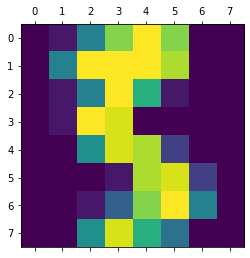

Predicted 1 instead of 8
Image for digit 8


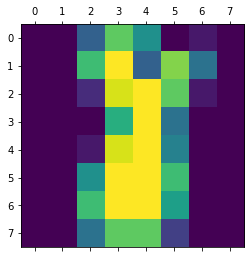

Number of mismatches ::  14
Count for 0 is 178
Count for 1 is 182
Count for 2 is 177
Count for 3 is 183
Count for 4 is 181
Count for 5 is 182
Count for 6 is 181
Count for 7 is 179
Count for 8 is 174
Count for 9 is 180


In [ ]:
#BEGIN 3.1a
#TODO: Print out problem class images
numbers = Numbers() #for default k=5
c_matrix = numbers.classify()
numbers.display_confusion(c_matrix)
numbers.mistakes_report()
numbers.number_count()
#END 3.1a

3.1.a 

*   There are 14 misclassifications that we can observe from the above confusion matrix. And the counts are also evenly spread across all the classes from 0-9. Therefore it is not the case of imbalanced dataset to influence the class label. 

*   From the confusion matrix we can observe the most problematic classes are 8 and 3 with both of them making 4 errors each. If we look at the errors made by 8 it is classified as 1 twice 7 once and 9 once. In the case where it predicted 9 there is a clear ambiguity that we can witness between the image 9 and 8.


I can see majorly two reasons contributing to the incorrect classifications. 

*   The image pixel that we have obtained might not have been that clear enough for the model to classify/distinguish the image 
*   The value of K=5 might not be the optimal value for the model to correctly classify the digits



#### 3.1b
TODO: Write description of mis-classification

*   There are 14 misclassifications that we can observe from the above confusion matrix. And the counts are also evenly spread across all the classes from 0-9. Therefore it is not the case of imbalanced dataset to influence the class label. 

*   From the confusion matrix we can observe the most problematic classes are 8 and 3 with both of them making 4 errors each. If we look at the errors made by 8 it is classified as 1 twice 7 once and 9 once. In the case where it predicted 9 there is a clear ambiguity that we can witness between the image 9 and 8.


I can see majorly two reasons contributing to the incorrect classifications. 

*   The image pixel that we have obtained might not have been that clear enough for the model to classify/distinguish the image 
*   The value of K=5 might not be the optimal value for the model to correctly classify the digits

1 0.955
2 0.958
3 0.967
4 0.964
5 0.961
6 0.95
7 0.953
8 0.947
9 0.95
10 0.95
11 0.95
12 0.95
13 0.947
14 0.944
15 0.947
16 0.947
17 0.95
18 0.944
19 0.942
20 0.942
21 0.944
22 0.947
23 0.944
24 0.95
25 0.947
26 0.947
27 0.947
28 0.947
29 0.95
30 0.947
31 0.944
32 0.944
33 0.944
34 0.939
35 0.939
36 0.942
37 0.933
38 0.933
39 0.93
40 0.93
41 0.93
42 0.928
43 0.93
44 0.93
45 0.93
46 0.93
47 0.93
48 0.928
49 0.925
50 0.922
51 0.925
52 0.919
53 0.922
54 0.919
55 0.925
56 0.919
57 0.919
58 0.919
59 0.919
60 0.916
61 0.916
62 0.916
63 0.916
64 0.916
65 0.916
66 0.914
67 0.914
68 0.911
69 0.914
70 0.914
71 0.914
72 0.914
73 0.911
74 0.911
75 0.911
76 0.911
77 0.911
78 0.911
79 0.911
80 0.911
81 0.908
82 0.905
83 0.905
84 0.905
85 0.903
86 0.897
87 0.9
88 0.9
89 0.903
90 0.903
91 0.903
92 0.897
93 0.897
94 0.894
95 0.891
96 0.889
97 0.889
98 0.886
99 0.886
100 0.889


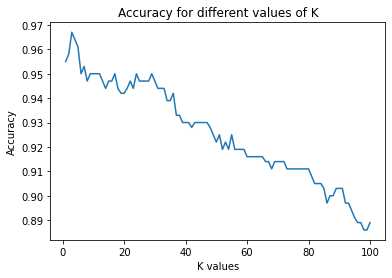

In [ ]:
#BEGIN 3.2a
#TODO: Run evaluation for different K and plot K vs Accuracy

k_values = []
accuracy_scores_test = []


for k in range(1,101):
  numbers = Numbers(k) #for all values of K from 1-100
  c_matrix = numbers.classify()
  k_values.append(k)
  accuracy_scores_test.append(round(numbers.accuracy(),3))


res = "\n".join("{} {}".format(x, y) for x, y in zip(k_values, accuracy_scores_test))
print(res)

plt.title('Accuracy for different values of K')
plt.xlabel('K values')
plt.ylabel('Accuracy')
plt.plot(k_values,accuracy_scores_test)
plt.show()

#END 3.2a

#### 3.2b
TODO: Write of effect of K on classifier accuracy

In the K-NN model the K value plays a huge role on accuracy. Because based on K value only, we take the majority vote and classify the given query point. If we choose a small K value the train error will be low but the test error will be high (overfitting). but when we pick a high K value it gives high error on both train and test data set (underfitting). As we can clearly see from the above plot that the model performs slightly better when K=3 than K=5 So let us try to construct the confusion matrix for K=3

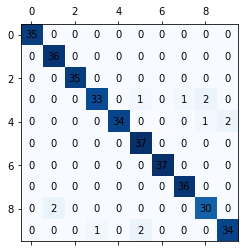

Predicted 1 instead of 8
Image for digit 8


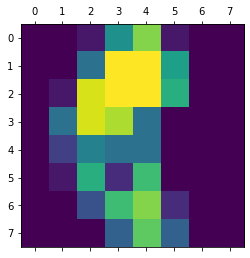

Predicted 5 instead of 9
Image for digit 9


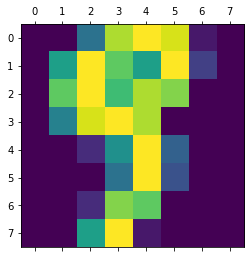

Predicted 7 instead of 3
Image for digit 3


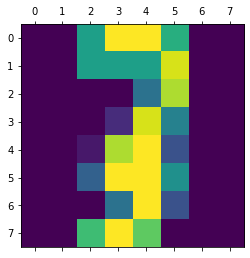

Predicted 8 instead of 3
Image for digit 3


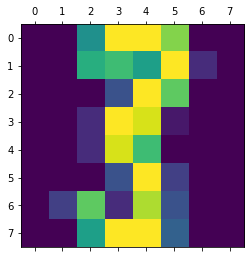

Predicted 9 instead of 4
Image for digit 4


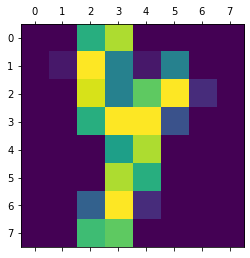

Predicted 9 instead of 4
Image for digit 4


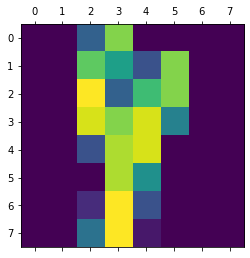

Predicted 3 instead of 9
Image for digit 9


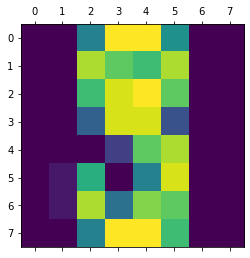

Predicted 8 instead of 4
Image for digit 4


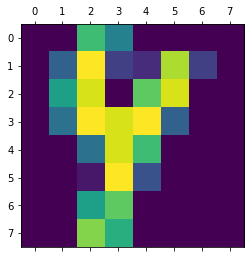

Predicted 5 instead of 9
Image for digit 9


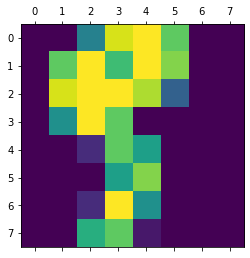

Predicted 8 instead of 3
Image for digit 3


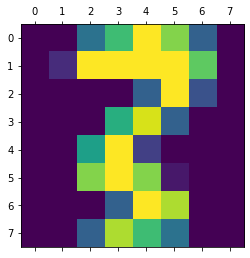

Predicted 5 instead of 3
Image for digit 3


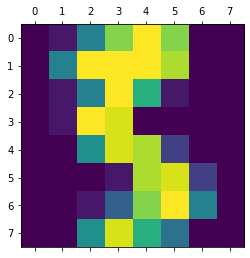

Predicted 1 instead of 8
Image for digit 8


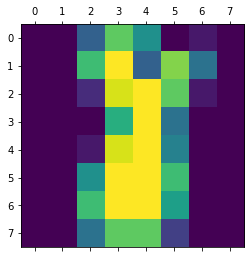

Number of mismatches ::  12


In [ ]:
#constructing confusion matrix for K=3 which has the highest accuracy as per the plot that we have derived

numbers = Numbers(3)
c_matrix = numbers.classify()
numbers.display_confusion(c_matrix)
numbers.mistakes_report()

The number of mismatched points were 14 when K=5 but it is slightly less (12) when K=3 therefore picking the right K has an impact on the performance of the model

In [ ]:

class NumbersKnobs(Numbers):
    """ Inherits from Numbers, so feel free to use methods from Numbers
    """

    def __init__(self, k=5, train_ratio=0.8):
        #load data from sklearn
        self._k = k
        self.train_ratio = train_ratio
        
        data = sklearn.datasets.load_digits()
        features = data["data"]
        labels = data["target"]
        features = features.reshape(features.shape[0], -1)

        percent = math.floor(len(features)*train_ratio)
        train_data = features[0:percent+1]
        train_labels = labels[0:percent+1]

        test_data = features[percent:-1]
        test_labels = labels[percent:-1]

        #BEGIN Workspace 3.3a
        self.train_x = np.array(train_data) # A 2D np.array of training examples, REPLACE
        self.train_y = np.array(train_labels) # A 1D np.array of training answers, REPLACE
        self.test_x = np.array(test_data) # A 2D np.array of testing examples, REPLACE
        self.test_y = np.array(test_labels) # A 1D np.array of testing answers, REPLACE
        self.classifier = KNNClassifier() # KNNClassifier, REPLACE


    def classify(self):
      count = 0
      model = self.classifier.fit( self.train_x,  self.train_y)
      c_matrix = model.confusion_matrix(self.test_x, self.test_y)
      Y_predicted = model.predict(self.test_x)
      return  c_matrix


    def mistakes_report(self):
        model = self.classifier.fit( self.train_x,  self.train_y)
        Y_predicted = model.predict(self.test_x)
        count = 0
        for idx in range(0,len(Y_predicted)):
          if Y_predicted[idx]!=self.test_y[idx]:
            count+=1
            print('Predicted {} instead of {}'.format(Y_predicted[idx], self.test_y[idx]))
            digit_image = self.test_x[idx]
            image = digit_image.reshape(8, -1)
            print("Image for digit {}".format(self.test_y[idx]))
            plt.matshow(image)
            plt.show()
        print("Number of mismatches :: ", count)
    
    def accuracy(self):
        c_matrix = self.classify()
        accuracy = np.sum(c_matrix.diagonal())/c_matrix.sum()
        return accuracy

0.5: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
0.6: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
0.7: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
0.8: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
0.9: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
[[0.95434298 0.95434298 0.95434298 0.95434298 0.95434298 0.95434298
  0.95434298 0.95434298 0.95434298 0.95434298 0.95434298 0.95434298
  0.95434298 0.95434298 0.95434298 0.95434298 0.95434298 0.95434298
  0.95434298 0.95434298 0.95434298 0.95434298 0.95434298 0.95434298
  0.95434298]
 [0.95821727 0.95821727 0.95821727 0.95821727 0.95821727 0.95821727
  0.95821727 0.95821727 0.95821727 0.95821727 0.95821727 0.95821727
  0.95821727 0.95821727 0.95821727 0.95821727 0.95821727 0.95821727
  0.95821727 0.95821727 0.95821727 0.95821727 0.95821727 0.95821727
  0.95821727]
 [0.96289425 0.96289425 0.96289425 0.96289425 0.96289425 0.96289425
  0.9

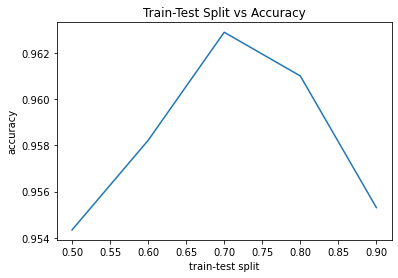

In [ ]:
#BEGIN Workspace 3.3b
#TODO: analyze the effect of split ratio
k = 5
repetitions = 25 # Feel free to increase it
split_ratios = np.array([0.5, 0.6, 0.7, 0.8, 0.9])
results = np.zeros((len(split_ratios),repetitions))
for i, s in enumerate(split_ratios):
    print(s ,end =": ")
    for j in range(repetitions):
        print(j, end=",")
        numbers = NumbersKnobs(k=k, train_ratio=s)
        results[i,j] = numbers.accuracy() # TODO get accuracy of classification
    print("")
# Add title axis labels to the plot

print(results)
plt.title('Train-Test Split vs Accuracy')
plt.xlabel('train-test split')
plt.ylabel('accuracy')
plt.plot(split_ratios, results.mean(1))

#END Workspace 3.3b

#### 3.3b
TODO: Write of effect of varying the split ratio, ultimately, you can run the classification several times for a fixed K and different split ratios

As we can clearly from the above plot that, more the training data that we give to the model more the accuracy will be. Because for 0.5 train and 0.5 test data the accuracy was less compared to 0.6 train and 0.4 test which in turn is lesser than 0.7 train 0.3 test split. Therefore train-test split clearly has effect on the accuracy, more data ratio, we give to the model to train more will be its accuracy. But we must also be careful that we don't overtrain the model, list we must hit the optimal balance so that we have considerable amount of unseen data points to measure the performance of the model.

### Problem 4 : Improving KNN on MNIST using WeightedKNN (30 pts)
Complete the `WeightedKNNClassifier` class to perform the weighted KNN classification.
The Weighted KNN classifier assigns weights to the nearest-neighbor training examples proportional to the inverse-distance from the training example to the query point. Classification is performed by summing the weights associated with each class and predicting the class with the highest weighted-majority vote. Mathematically we might describe the weighted-vote for a class $c$ as 

$$
\textrm{Weighted-Vote}(c)(x) = \sum_{i \in {\cal N}_K(x)} I(y_i \in c) \times \frac{1}{\|{\bf x}_i - {\bf x}\|}
$$
where ${\cal N}_K(x)$ is the set of the closest $k$ neighbors to $x$


4.1 Complete the `fit` method in a similar way to `KNNClassifier` (5 pts)

4.2 Complete `majority_vote`: it's certainly possible that a query point could be distance $0$ away from some training example. If this happens your implementation should handle it and return the appropriate class label. (5 pts)

4.3 Complete `predict` (5 pts)

4.4 Compete `confusion_matrix` and `accuracy` methods (5 pts)

4.5 Compare `KNNClassifier` and `WeightedKNNClassifier` for multiple $K$, make sure that for each run both classifers are fitted using the same train/test split. You can execute multiple runs to mitigate the split randomness. Report for which K you get the best accuracy for each classifier and the best overall classifier. (10 pts)


In [ ]:
class WeightedKNNClassifier:

    """
    Class to store data for regression problems 
    """
    def __init__(self, k):

        """
        Creates a kNN instance
        :param k: The number of nearest points to consider in classification
        """
        
        # Import and build the BallTree on training features 
        self._k = k
        self._model = None
        self._y = None
        self.counts = 0
        
        # Boolean flag indicating whether to do distance weighting (if you want to make it versatile)

    def get_counts(self):
      counts = dict()
      for i in self._y:
        counts[i] = counts.get(i,0)+1
      return counts
  
    def fit(self, features, labels):
        
        # BEGIN Workspace 4.1
        self._model = sklearn.neighbors.BallTree(features) # REPLACE
        self._y = np.array(labels) #  REPLACE
        self.counts = self.get_counts()

        #END Workspace 4.1

        # Should be used to map set of classes to {0,1,..C-1} where C is the number of classes
        classes = list(set(list(labels)))
        self.label_to_index = dict(zip(sorted(classes), range(len(classes))))
        self.index_to_label = dict(zip(range(len(classes)), sorted(classes)))
        return self



    def majority_vote(self, neighbor_indices, neighbor_distances=None):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param neighbor_indices: The indices of the K nearest neighbors in self.X_train 
        :param neighbor_distances: Corresponding distances from query point to K nearest neighbors. 
        """
        # YOUR CODE HERE
        #BEGIN Workspace 4.2
        labels = [] #REPLACE
        #END Workspace 4.2


        if len(neighbor_indices) != self._k:
          print("Number of indices given is less than number of Neighbours K")
          return;


        weighted_vote_store = {} # to store the classes of the neighbours and their counts in the dictionary
        for idx,dist in zip(neighbor_indices, neighbor_distances):
          temp = self._y[idx]
          if dist == 0: #dividing by zero error
            weighted_vote_store[temp] = weighted_vote_store.get(temp,0)+0;
          else:
            weighted_vote_store[temp] = weighted_vote_store.get(temp,0)+(1/dist);
            
        max_weight = max(weighted_vote_store.values()) #maximum weight associated with which class in the dictionary to determine which class has got the majority weight
        
        classes_with_max_keys = [] #we weill store the classes which has secured max_weight in a list
        for key in weighted_vote_store:
          if weighted_vote_store[key] == max_weight:
            classes_with_max_keys.append(key);


        if len(classes_with_max_keys)==1: #there is only one element in the list therefore we will assign the value at the 0th index to the labels and then return
          labels = classes_with_max_keys[0];

        else: #if the list contains more than one element then it is a tie then return the class label which is the majority
          train_data_classes_frequencies = self.get_counts()
          maximum_frequency = 0
          for key in classes_with_max_keys: #iterate over classes with max keys
            if train_data_classes_frequencies[key] > maximum_frequency: #determine which class had occured more in the training data set
              maximum_frequency = train_data_classes_frequencies[key]; #keep track of the maximum_frequency
              labels = key;#assign that class to the labels which we have to return
      
        return labels # return the classes with majority vote
    
    def predict(self, features):
        """
        Given an np.array of query points, return y_hat, an np.array of predictions

        :param features: an (m x p) dimension np.array of points to predict labels for
        """
        labels = None
        # YOUR CODE HERE
        #BEGIN Workspace 4.3
        #TODO: predict labels
        #END Workspace 4.3

        predicted_answers = []
        distances, indices = self._model.query(features, self._k)
        for idx,dist in zip(indices,distances):
          predicted_answers.append(self.majority_vote(idx,dist))
        labels = np.array(predicted_answers)
        return labels

    def confusion_matrix(self, features_test, labels_test):
        """
        Generate a confusion matrix for the given test set
        PARAMETERS
        testX - an np.array of feature vectors of test points
        testY - the corresponding correct classifications of our test set
        RETURN
        C - an N*N np.array of counts, where N is the number of classes in our classifier
        """
        c_matrix = np.array(None)
        #BEGIN Workspace 4.4.a
        #TODO: Run classification for the test set, compare to test answers, and add counts to matrix
            
        #END Workspace 4.4.a

        labels_test_set = set(labels_test)
        c_matrix = np.zeros((len(labels_test_set),len(labels_test_set)), dtype=int)
        predicted_test = self.predict(features_test)

        for predicted, actual in zip(predicted_test, labels_test):
          c_matrix[actual][predicted]+=1;
      
    
        return c_matrix
    
    def accuracy(self, features_test, labels_test):
        """
        Generate an accuracy score for the classifier based on the confusion matrix
        PARAMETERS
        C - an np.array of counts
        RETURN
        score - an accuracy score
        """
        score = 0
        #BEGIN Workspace 4.4.b
        #TODO: Compute accuracy of the classification of features_test
        c_matrix = self.confusion_matrix(features_test, labels_test)
        score = np.sum(c_matrix.diagonal())/c_matrix.sum()
        #END Workspace 4.4.b
        return score 
       

In [ ]:
class NumbersWeighted(NumbersKnobs):
    def __init__(self, k=5, train_ratio=0.8):
        super(NumbersWeighted, self).__init__(k, train_ratio)
        self.classifier = WeightedKNNClassifier(k=self._k)
        

1: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
2: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
3: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
4: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
5: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
6: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
7: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
8: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
9: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
10: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
11: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
12: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
13: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
14: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
15: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
16: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
32: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
50: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
[[0.95543175 0.9554

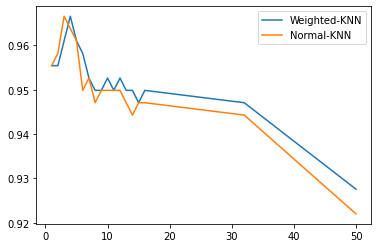

Maximal accuracy for weighted KNN is 0.966573816155989 at K equals 4
Maximal accuracy for Normal KNN is 0.966573816155989 at K equals 3


In [ ]:
#BEGIN Workspace 4.5
#TODO: Run multiple comparisons
repetitions = 20
ks = [1, 2, 3, 4, 5, 6, 7,8,9,10,11,12,13,14,15,16,32,50] # Add more
results_simple = np.zeros((len(ks),repetitions))
results_weighted = np.zeros((len(ks),repetitions))
data = sklearn.datasets.load_digits()
features = data["data"]
labels = data["target"]
features = features.reshape(features.shape[0], -1)

#80-20 split        
eighty_percent = math.floor(len(features)*0.8)
train_data = features[0:eighty_percent]
train_labels = labels[0:eighty_percent]

test_data = features[eighty_percent:-1]
test_labels = labels[eighty_percent:-1] 


weighted = []
normal = []

for i, k in enumerate(ks):
    print(k,end =": ")
    for j in range(repetitions):
        print(j, end=",")
        numbers = NumbersWeighted(k=k)
        model = numbers.classifier.fit(train_data, train_labels)
        results_weighted[i,j] = model.accuracy(test_data,test_labels)
        numbers.classifier = KNNClassifier(k=numbers._k)
        model = numbers.classifier.fit(train_data, train_labels)
        results_simple[i,j] =  model.accuracy(test_data, test_labels)

    weighted.append(sum(results_weighted[i])/len(results_weighted[i]))
    normal.append(sum(results_simple[i])/len(results_simple[i]))
    print("")

#TODO Average results over multiple runs and report best classifier

print(results_weighted)
print(results_simple)

plt.plot(ks,weighted, label='Weighted-KNN')
plt.plot(ks,normal, label='Normal-KNN')
plt.legend()
plt.show()


max_accuracy_weighted = 0
max_accuracy_normal = 0
optimal_k_weighted = 0
optimal_k_normal = 0

for idx in range(0,len(weighted)):
  if weighted[idx] > max_accuracy_weighted:
    max_accuracy_weighted = weighted[idx]
    optimal_k_weighted = ks[idx]

  if normal[idx] > max_accuracy_normal:
    max_accuracy_normal = normal[idx]
    optimal_k_normal = ks[idx]


print('Maximal accuracy for weighted KNN is {} at K equals {}'.format(max_accuracy_weighted, optimal_k_weighted))
print('Maximal accuracy for Normal KNN is {} at K equals {}'.format(max_accuracy_normal, optimal_k_normal))

#END Workspace 4.5

#### 4.5

As we can clearly see from the above plot the weighted KNN performs better than the normal KNN as the K value increases. Because since it calculates based on the inverse of distance, the more closer points are taken compared to the normal KNN which selects class labels based on the majority vote of classes all the K neighbours combined.

#### Bonus (5 Points)
__4.6 Is `WeightedKNNClassifier` a consistent classifier? why or why not?__

*4.6 bonus response here*


1. Certain classifier works well on the training data and performs very badly on test (unseen) data. Then it is a overfit (high variance). Certain classifiers have both train error and test error high. It is an underfit (high bias). Consistent classifier should have the accuracy difference between them as minimal as possible so that's the optimal K so it performs better on both train data and test data.


2. I feel Weighted KNN is a consistent classifier because rather than just taking the majority vote of classes which might get impacted when the dataset is highly imbalanced. But in weighted KNN we take into account which is the closest point so the query point might likely to resemble the closest point. Let us take for example k=5 (4 points of one class are slightly far from the query point but one point of different class is closer to the query point) In majority vote we will pick the one class where there are 4 points despite the points being considerably far. But whereas, in weighted KNN we will check the distances also into account. So I feel, weighted KNN is a consistent classifier. 